## Exercises 4

## Data Extraction
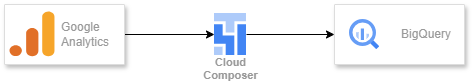 <br>

#### Authentication and Access
To extract data from the Google Analytics API, we'll need to set up authentication and authorize the application: <br>
##### Google Cloud Platform Setup:
- Create a new project in Google Cloud Platform (GCP).
- Enable the Google Analytics API.
- Create OAuth 2.0 credentials to get a client ID and client secret.
##### Service Account:
- Create a service account in GCP. <br>
- Grant the service account access to the Google Analytics view. <br>
- Download the JSON key file for the service account. <br>
<br>
## Data Pipeline
To automate the execution of the ETL we’ll use Google Cloud Composer so that it runs weekly, we’ll follow these steps: <br>
- ##### Configure Cloud Composer: 
We need to have the Google Cloud Composer environment set up. <br>


- ##### Create the DAG (Directed Acyclic Graph) in Airflow:
Create a DAG that runs weekly to pull data from Google Analytics and load it into BigQuery. <br>

#### DAG to Run the ETL Weekly
First, we need to create a Python file to define the DAG in the Cloud Composer environment. <br>
File path in Cloud Composer:<br>
##### /home/airflow/gcs/dags/etl_google_analytics_to_bigquery.py

<a href = "https://github.com/katerinneramos/data-engineer-technical-test/blob/addProyect/4TechnicalTest/etl_google_analytics_to_bigquery.py">Link to etl_google_analytics_to_bigquery.py</a>


In [ ]:
# etl_google_analytics_to_bigquery.py
from airflow import DAG
from airflow.utils.dates import days_ago
from airflow.operators.python_operator import PythonOperator
from google.oauth2 import service_account
from googleapiclient.discovery import build
from google.cloud import bigquery
from datetime import datetime, timedelta

# Define default arguments
default_args = {
    'owner': 'airflow',
    'depends_on_past': False,
    'email_on_failure': False,
    'email_on_retry': False,
    'retries': 1,
}

# Define the DAG
dag = DAG(
    'etl_google_analytics_to_bigquery',
    default_args=default_args,
    description='ETL pipeline for Google Analytics to BigQuery',
    schedule_interval='@weekly',  # Run once a week
    start_date=days_ago(1),
    catchup=False,
)

# Function to extract data from Google Analytics and load to BigQuery
def extract_load():
    SCOPES = ['https://www.googleapis.com/auth/analytics.readonly']
    SERVICE_ACCOUNT_FILE = '/path/to/service-account-file.json'
    credentials = service_account.Credentials.from_service_account_file(
        SERVICE_ACCOUNT_FILE, scopes=SCOPES)
    
    # Initialize Analytics Reporting API
    analytics = build('analyticsreporting', 'v4', credentials=credentials)

    # Define the date range (last 7 days)
    date_range = {
        'startDate': '7daysAgo',
        'endDate': 'yesterday'
    }

    # Define the metrics and dimensions
    metrics = [
        {'expression': 'ga:sessions'},
        {'expression': 'ga:pageviews'},
        {'expression': 'ga:users'},
        {'expression': 'ga:bounceRate'},
        {'expression': 'ga:conversionRate'},
        {'expression': 'ga:average_session_duration'}
    ]
    dimensions = [
        {'name': 'ga:date'},
        {'name': 'ga:deviceCategory'},
        {'name': 'ga:country'}
    ]

    # Make the API request
    request = analytics.reports().batchGet(
        body={
            'reportRequests': [
                {
                    'viewId': 'YOUR_VIEW_ID',
                    'dateRanges': [date_range],
                    'metrics': metrics,
                    'dimensions': dimensions
                }]
        }
    ).execute()

    # Process the request and transform data for BigQuery
    rows = []
    for report in request.get('reports', []):
        for row in report.get('data', {}).get('rows', []):
            date = row.get('dimensions', [])[0]
            devices = row.get('dimensions', [])[1]
            geography = row.get('dimensions', [])[2]
            metrics_data = row.get('metrics', [])[0].get('values', [])
            rows.append({
                'week_start_date': date,
                'sessions': int(metrics_data[0]),
                'pageviews': int(metrics_data[1]),
                'users': int(metrics_data[2]),
                'bounce_rate': float(metrics_data[3]),
                'conversion_rate': float(metrics_data[4]),
                'devices': devices,
                'geography': geography,
                'average_session_duration': float(metrics_data[5])
            })

    # Load data into BigQuery
    client = bigquery.Client()
    table_id = 'demo-dbt-project.analytics.weekly_analytics_report'
    errors = client.insert_rows_json(table_id, rows)

    if errors:
        print(f'Encountered errors while inserting rows: {errors}')
    else:
        print('Rows successfully inserted.')

# Define the PythonOperator to run the extract_load function
run_etl = PythonOperator(
    task_id='run_etl',
    python_callable=extract_load,
    dag=dag,
)

run_etl


#### Cloud Composer’s implementation
- ##### Upload the file to the DAG directory:
Upload etl_google_analytics_to_bigquery.py to the Cloud Storage bucket associated with your Cloud Composer environment.

- ##### Verify the DAG in the Airflow UI:
Verify that the etl_google_analytics_to_bigquery DAG is listed and enabled.

- ##### Run and monitor the DAG:
Monitors the execution of the DAG to verify that data is correctly extracted and loaded into BigQuery.


## Data Modeling
Table to store the etl_google_analytics_to_bigquery <br>
<br>
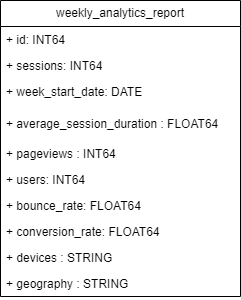

<a href = "https://github.com/katerinneramos/data-engineer-technical-test/blob/addProyect/4TechnicalTest/weekly_analytics_report.sql">Link to Create Table Query: weekly_analytics_report.sql</a>

In [ ]:
CREATE TABLE `demo-dbt-project.analytics.weekly_analytics_report` (
    week_start_date DATE OPTIONS(description="The starting date of the week")
    ,sessions INT64 OPTIONS(description="Total number of sessions")
    ,pageviews INT64 OPTIONS(description="Total number of pageviews")
    ,users INT64 OPTIONS(description="Total number of unique users")
    ,bounce_rate FLOAT64 OPTIONS(description="Percentage of single-page sessions")
    ,conversion_rate FLOAT64 OPTIONS(description="Rate of goal conversions")
    ,devices STRING OPTIONS(description="Types of devices used by users")
    ,geography STRING OPTIONS(description="Geographical location of users")
    ,average_session_duration FLOAT64 OPTIONS(description="Average duration of sessions in seconds")
);


### Using dbt for Data Modeling
We'll use DBT for data modeling and automating the data transformation process. <br> 
We need to define dbt models to handle the extraction and transformation of data, and then calculate the week-over-week metrics. <br>

We create an staging, intermediate and final model.

### Staging Model

In [ ]:
{{ config(
    materialized = 'view'
) }}

WITH raw_data AS (

    SELECT
        week_start_date,
        sessions,
        pageviews,
        users,
        bounce_rate,
        conversion_rate,
        average_session_duration,
        devices,
        geography
    FROM
        {{ source('analytics', 'weekly_analytics_report') }}
)
SELECT
    week_start_date,
    sessions,
    pageviews,
    users,
    bounce_rate,
    conversion_rate,
    average_session_duration,
    devices,
    geography
FROM
    raw_data


### Intermediate Model

In [ ]:
{{ config(
    materialized = 'view'
) }}

WITH weekly_data AS (

    SELECT
        week_start_date,
        SUM(sessions) AS sessions,
        SUM(pageviews) AS pageviews,
        SUM(users) AS users,
        AVG(bounce_rate) AS bounce_rate,
        AVG(conversion_rate) AS conversion_rate,
        AVG(average_session_duration) AS average_session_duration
    FROM
        {{ ref('week_over_week_analytics_stg') }}
    GROUP BY
        week_start_date
)
SELECT
    week_start_date,
    sessions,
    pageviews,
    users,
    bounce_rate,
    conversion_rate,
    average_session_duration
FROM
    weekly_data


### Final Model for Week-over-Week Metrics

In [ ]:
{{ config(
    materialized='table'
) }}

WITH weekly_data_lag AS (
    SELECT
        week_start_date,
        sessions,
        pageviews,
        users,
        bounce_rate,
        conversion_rate,
        average_session_duration,
        LAG(sessions) OVER (ORDER BY week_start_date) AS prev_sessions,
        LAG(pageviews) OVER (ORDER BY week_start_date) AS prev_pageviews,
        LAG(users) OVER (ORDER BY week_start_date) AS prev_users,
        LAG(bounce_rate) OVER (ORDER BY week_start_date) AS prev_bounce_rate,
        LAG(conversion_rate) OVER (ORDER BY week_start_date) AS prev_conversion_rate,
        LAG(average_session_duration) OVER (ORDER BY week_start_date) AS prev_avg_session_duration
    FROM
        {{ ref('week_over_week_analytics_int') }}
)

SELECT
    week_start_date,
    sessions,
    pageviews,
    users,
    bounce_rate,
    conversion_rate,
    average_session_duration,
    prev_sessions,
    prev_pageviews,
    prev_users,
    prev_bounce_rate,
    prev_conversion_rate,
    prev_avg_session_duration,
    SAFE_DIVIDE(sessions - prev_sessions, prev_sessions) * 100 AS pct_change_sessions,
    SAFE_DIVIDE(pageviews - prev_pageviews, prev_pageviews) * 100 AS pct_change_pageviews,
    SAFE_DIVIDE(users - prev_users, prev_users) * 100 AS pct_change_users,
    SAFE_DIVIDE(bounce_rate - prev_bounce_rate, prev_bounce_rate) * 100 AS pct_change_bounce_rate,
    SAFE_DIVIDE(conversion_rate - prev_conversion_rate, prev_conversion_rate) * 100 AS pct_change_conversion_rate,
    SAFE_DIVIDE(average_session_duration - prev_avg_session_duration, prev_avg_session_duration) * 100 AS pct_change_avg_session_duration
FROM
    weekly_data_lag
ORDER BY
    week_start_date;


#### For this we need to set up the profiles.yml file with your BigQuery configuration:

In [ ]:
dmo_dbt:
  outputs:
    dev:
      dataset: analytics
      job_execution_timeout_seconds: 600
      job_retries: 1
      location: US
      method: oauth
      priority: interactive
      project: demo-dbt-project
      threads: 2
      type: bigquery
  target: dev


#### And configure the schema.yml as follow:

In [ ]:
version: 2

models:
  - name: week_over_week_analytics_stg
    description: "Week Analytics Stage"
    columns:
      - name: id
        description: "The primary key for this table"
        data_tests:
          - unique
          - not_null

  - name: week_over_week_analytics_int
    description: "Week Analytics Intermediate"
    columns:
      - name: id
        description: "The primary key for this table"
        data_tests:
          - unique
          - not_null

  - name: week_over_week_analytics
    description: "Week Analytics Intermediate"
    columns:
      - name: id
        description: "The primary key for this table"
        data_tests:
          - unique
          - not_null


#### And configure de source.yml

In [ ]:
version: 2

sources:
  - name: analytics
    tables:
      - name: weekly_analytics_report
